# Sentiment Analysis with PyTorch and Sentence Transformers

In [12]:
# ------------------
# 2. Import Libraries
# ------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sentence_transformers import SentenceTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
# ------------------
# 3. Load Dataset
# ------------------
# We'll use the Sentiment140 dataset which contains 1.6 million tweets classified as negative or positive.
# Labels: 0 = negative, 4 = positive

tweets = pd.read_csv("sentiment_dataset.csv", encoding='ISO-8859-1', names=["target", "ids", "date", "flag", "user", "text"], skiprows=1)
tweets.drop(['ids','date','flag','user'], axis=1, inplace=True)
tweets['target'] = tweets['target'].replace(4,1)

print(tweets.tail())

# Split into train, validation, test
train_tweets, test_tweets = train_test_split(tweets, test_size=0.2, random_state=42)

print(train_tweets.shape, test_tweets.shape)

        target                                               text
499994       1  If your not already follow my cuzzo @VocallyBl...
499995       1               @ddlovato  hey we love U 2  rock on 
499996       1  @NickyLovesMcFly There are.  On http://www.mcf...
499997       1  There, done my bit to introduce competitive co...
499998       1  just finished updating his blog; Steve Pavlina...
(399999, 2) (100000, 2)


In [39]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.texts = dataframe["text"]
        self.labels = dataframe["target"]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        try:
            label = int(self.labels.iloc[idx])
        except:
            print(self.labels.iloc[idx], idx)


        return text, label

train_dataset = CustomDataset(train_tweets)
test_dataset = CustomDataset(test_tweets)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

In [40]:
# ------------------
# 6. Classifier Model
# ------------------
# We'll define a simple feed-forward neural network classifier.
# Input size = embedding dimension (from Sentence Transformer)
# Output size = 2 (negative, positive)

class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [41]:
# ------------------
# 7. Training Setup
# ------------------

embedding_model = SentenceTransformer("paraphrase-MiniLM-L3-v2").to(device)
embedding_model.eval()

# Get embedding size
sample_embedding = embedding_model.encode("This is a test", convert_to_tensor=True)
input_dim = sample_embedding.shape[0]
print(input_dim)

model = SentimentClassifier(input_dim=input_dim, hidden_dim=64, num_classes=2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

384


In [42]:
# ------------------
# 7. Training Loop
# ------------------
num_epochs = 1
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for texts, labels in tqdm(train_loader):
        with torch.no_grad():
          embeddings = embedding_model.encode(texts, convert_to_tensor=True).clone()

        embeddings = embeddings.to(device)
        labels = labels.to(device)

        outputs = model(embeddings)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)   # batch size

        train_losses.append(total_loss / total)
        train_accs.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for texts, labels in tqdm(test_loader):
            with torch.no_grad():
              embeddings = embedding_model.encode(texts, convert_to_tensor=True).clone()

            embeddings = embeddings.to(device)
            labels = labels.to(device)

            outputs = model(embeddings)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)   # batch size

            val_losses.append(val_loss / val_total)
            val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Loss {train_losses[-1]:.4f}, Train Acc {train_accs[-1]:.4f}, Val Loss {val_losses[-1]:.4f}, Val Acc {val_accs[-1]:.4f}")

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1: Train Loss 0.0020, Train Acc 0.7468, Val Loss 0.0019, Val Acc 0.7585


In [43]:
# ------------------
# 9. Test Evaluation
# ------------------
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for texts, labels in tqdm(test_loader):
        embeddings = embedding_model.encode(texts, convert_to_tensor=True).clone().detach().to(device)
        labels = torch.tensor(labels).to(device)


        outputs = model(embeddings)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative","Positive"]))

  0%|          | 0/391 [00:00<?, ?it/s]

/tmp/ipython-input-640651343.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.75      0.76     49996
    Positive       0.76      0.76      0.76     50004

    accuracy                           0.76    100000
   macro avg       0.76      0.76      0.76    100000
weighted avg       0.76      0.76      0.76    100000



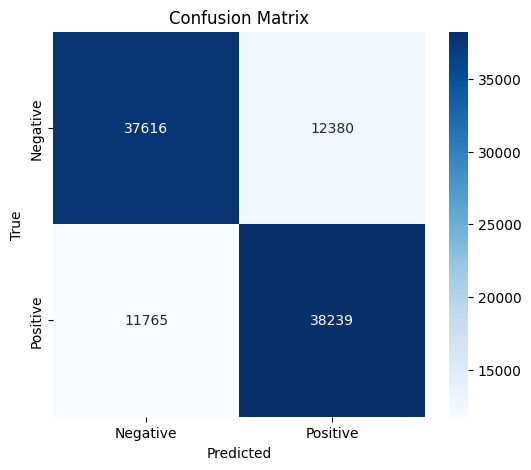

In [44]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [45]:
# ------------------
# 11. Quick Test on Some Examples
# ------------------
# This small snippet takes a few examples from the test dataset,
# runs them through the classifier, and prints the text, predicted label, and true label.
import random

model.eval()
with torch.no_grad():
  for i in range(10):
    idx = random.randint(0, len(test_dataset))
    text, true_label = test_dataset[idx]
    embedding = embedding_model.encode([text], convert_to_tensor=True).clone().detach().to(device)
    output = model(embedding)
    _, pred_label = torch.max(output, 1)
    label_map = {0: "Negative", 1: "Positive"}
    print(f"Text: {text}")
    print(f"Predicted: {label_map[pred_label.item()]}")
    print(f"True: {label_map[true_label]}\n")

Text: well time 2 get dress on this ugly ass day in la...dont know what im doin 2nite and thats the exact reason why i club every week  lol
Predicted: Negative
True: Negative

Text: @tayfoshayshay I miss you too! Come home pleaseeee 
Predicted: Negative
True: Negative

Text: @Devona09 wow you are absolutely beautiful I am more then happy to follow you..thanx! 
Predicted: Positive
True: Positive

Text: Now this is what I call a Saturday... God love the sun 
Predicted: Positive
True: Positive

Text: Theres a fly in my room. It's been here for a few days now. 
Predicted: Negative
True: Negative

Text: I am so tired this morning. 
Predicted: Negative
True: Negative

Text: @cottoncore My pleasure too! 
Predicted: Positive
True: Positive

Text: @Wafuku_kimonos aha!  Thanks.will have to wait till I am at somebody elses house then 
Predicted: Positive
True: Negative

Text: @4th_Long_Emoten thank u!! its under construction but the content is updated. pure hotness!   we can do a story on u too!
